# Tea Leaf Disease Classification Model

This notebook implements a Convolutional Neural Network (CNN) to classify tea leaf diseases based on images. The model can identify different types of tea leaf diseases and healthy leaves.

## Required Libraries
The following cell imports the necessary libraries:
- `tensorflow`: Main deep learning framework
- `keras`: High-level neural network API
- `matplotlib`: For data visualization
- `numpy`: For numerical computations
- `os`: For file operations
- `gc`: For garbage collection

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
import numpy as np
import os, gc

## Model Configuration
The following cell defines key parameters for the model:
- `BATCH_SIZE`: Number of images processed in each training iteration (32)
- `IMAGE_SIZE`: Dimensions to which all images will be resized (256x256)
- `CHANNELS`: Number of color channels in the images (3 for RGB)
- `EPOCHS`: Number of complete passes through the training dataset (30)

In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

## Dataset Loading
Loading the tea leaf disease dataset using TensorFlow's image dataset utilities. The dataset is loaded from the directory structure where each subdirectory represents a disease class. The images are:
- Shuffled for better training
- Resized to the specified image size
- Organized into batches
- Assigned class labels automatically based on folder names

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Tea_Leaf_Disease Dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5867 files belonging to 6 classes.


In [22]:
class_names = dataset.class_names
class_names

['algal_spot',
 'brown_blight',
 'gray_blight',
 'healthy',
 'helopeltis',
 'red_spot']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[4 2 3 2 2 4 2 1 3 3 2 5 4 0 4 1 4 5 4 2 0 4 1 0 1 4 2 4 3 4 5 5]


## Data Visualization
Visualizing sample images from the dataset to:
1. Verify correct data loading
2. Understand the visual characteristics of different disease classes
3. Check image quality and consistency
4. Confirm proper labeling

The following cells will display:
- Class names from the dataset
- Sample batch shape and labels
- A grid of sample images with their corresponding class labels

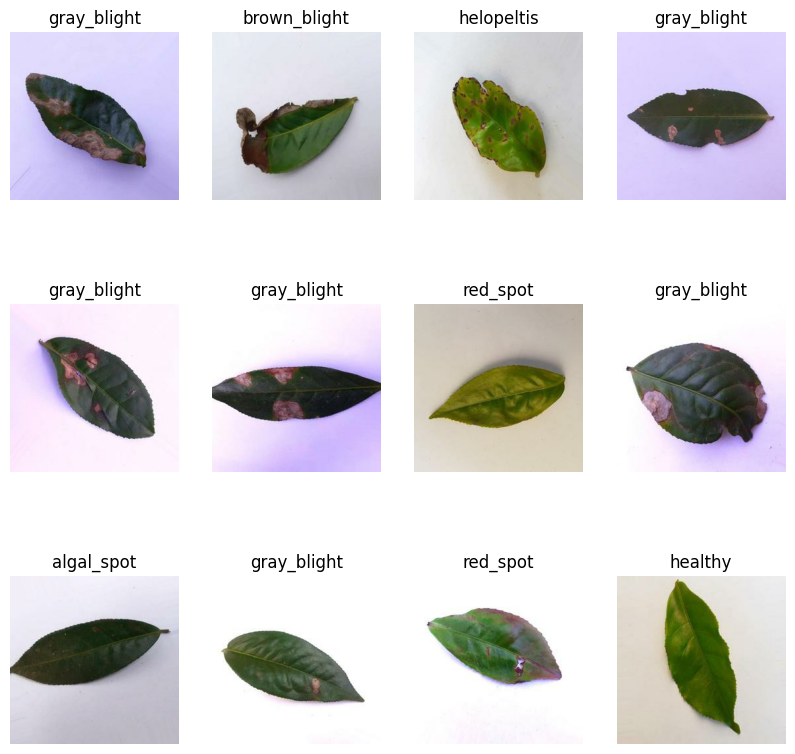

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

184

In [10]:
train_size = 0.8
len(dataset)*train_size

147.20000000000002

In [9]:
train_ds = dataset.take(147)
len(train_ds)

147

In [11]:
test_ds = dataset.skip(147)
len(test_ds)

37

In [12]:
val_size=0.1
len(dataset)*val_size

18.400000000000002

In [13]:
val_ds = test_ds.take(18)
len(val_ds)

18

In [14]:
test_ds = test_ds.skip(18)
len(test_ds)

19

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

## Dataset Splitting
The dataset is split into three parts:
1. Training set (80%): Used to train the model
2. Validation set (10%): Used to evaluate the model during training
3. Test set (10%): Used for final model evaluation

The function `get_dataset_partitions_tf` implements this splitting with options for:
- Custom split ratios
- Shuffling the dataset
- Configurable shuffle buffer size

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

147

In [17]:
len(val_ds)

18

In [18]:
len(test_ds)

19

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
	tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
	tf.keras.layers.Rescaling(1./255),
])

## Data Preprocessing and Augmentation

### Image Preprocessing
First, we apply basic preprocessing to standardize the images:
1. Resize all images to the specified dimensions (256x256)
2. Rescale pixel values from [0-255] to [0-1]

### Data Augmentation
To prevent overfitting and improve model generalization, we apply the following augmentation techniques:
1. Random horizontal and vertical flips
2. Random rotation up to 20% of full rotation

These transformations help create additional training examples and make the model more robust to variations in the input data.

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [20]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [23]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # No BATCH_SIZE here!
n_classes = 6

model = models.Sequential([
    Input(shape=input_shape),  # This is the "boss whisper"—tells the shape once at the start
    resize_and_rescale,        # Your preprocessing layer comes next
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),  # No input_shape here anymore!
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Now build with the shape *without* batch size
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))  # 'None' means any batch size

In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,942 (718.52 KB)

 Trainable params: 183,942 (718.52 KB)

 Non-trainable params: 0 (0.00 B)

## Model Architecture
We implement a Convolutional Neural Network (CNN) with the following architecture:

1. **Input Processing**:
   - Resize and rescale layer for consistent input

2. **Convolutional Layers**:
   - 6 blocks of Conv2D + MaxPooling2D layers
   - Each Conv2D layer uses 3x3 kernels and ReLU activation
   - MaxPooling2D layers with 2x2 pools for dimension reduction
   
3. **Classification Head**:
   - Flatten layer to convert 2D features to 1D
   - Dense layer with 64 neurons and ReLU activation
   - Output layer with softmax activation for 6 classes

This architecture is designed to effectively capture hierarchical features in leaf images for disease classification.

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## Model Compilation and Training

### Model Compilation
The model is compiled with:
- Adam optimizer: An adaptive learning rate optimization algorithm
- Sparse Categorical Crossentropy loss: Appropriate for multi-class classification with integer labels
- Accuracy metric: To monitor classification performance

### Model Training
The model will be trained for 50 epochs with:
- Batch size of 32 images
- Validation data to monitor overfitting
- Verbose output to track progress

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 98s 630ms/step - accuracy: 0.3684 - loss: 1.3868 - val_accuracy: 0.4010 - val_loss: 1.3272
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 88s 594ms/step - accuracy: 0.4852 - loss: 1.2015 - val_accuracy: 0.5434 - val_loss: 1.1056
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 86s 584ms/step - accuracy: 0.5471 - loss: 1.0822 - val_accuracy: 0.5226 - val_loss: 1.1310
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 87s 590ms/step - accuracy: 0.5738 - loss: 1.0218 - val_accuracy: 0.5833 - val_loss: 1.0300
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 86s 584ms/step - accuracy: 0.6214 - loss: 0.9331 - val_accuracy: 0.6024 - val_loss: 1.0423
Epoch 6/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 86s 584ms/step - accuracy: 0.6406 - loss: 0.8803 - val_accuracy: 0.6580 - val_loss: 0.8858
Epoch 7/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 87s 591ms/step - accuracy: 0.6526 - loss: 0.8570 - val_accuracy: 0.6684 - val_loss: 0.8209
Epoch 8/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 85s 575ms/step - accuracy: 0.6912 - loss: 0

In [27]:
# Create models directory if it doesn't exist
models_dir = "models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Save the model
model_path = os.path.join(models_dir, "tea_leaf_model.keras")
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to models\tea_leaf_model.keras


In [28]:
scores = model.evaluate(test_ds)

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9243 - loss: 0.2311


In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

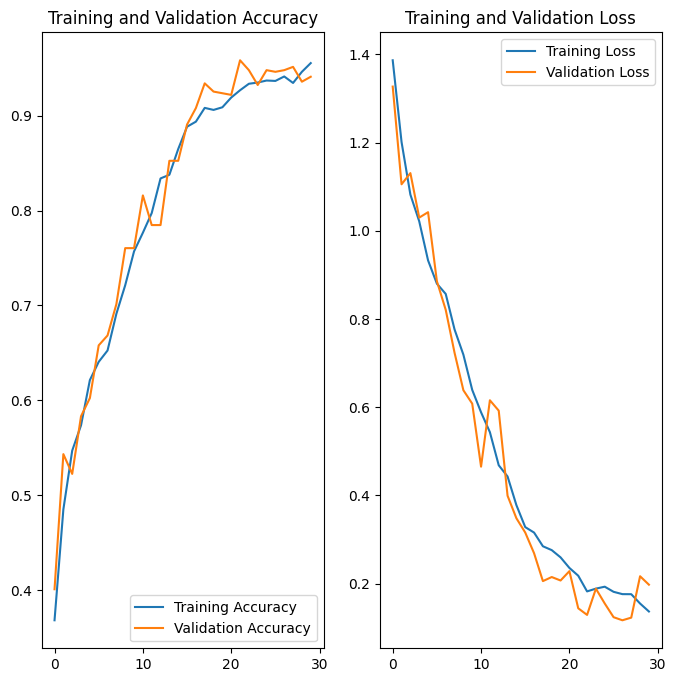

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: helopeltis
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
predicted label: helopeltis


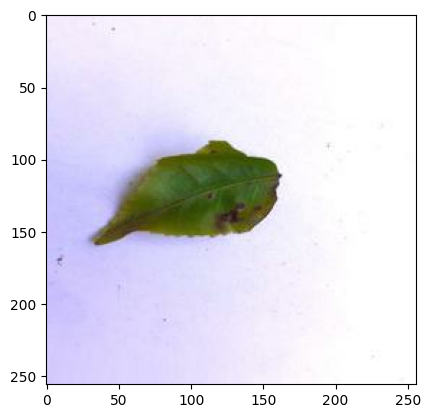

In [31]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


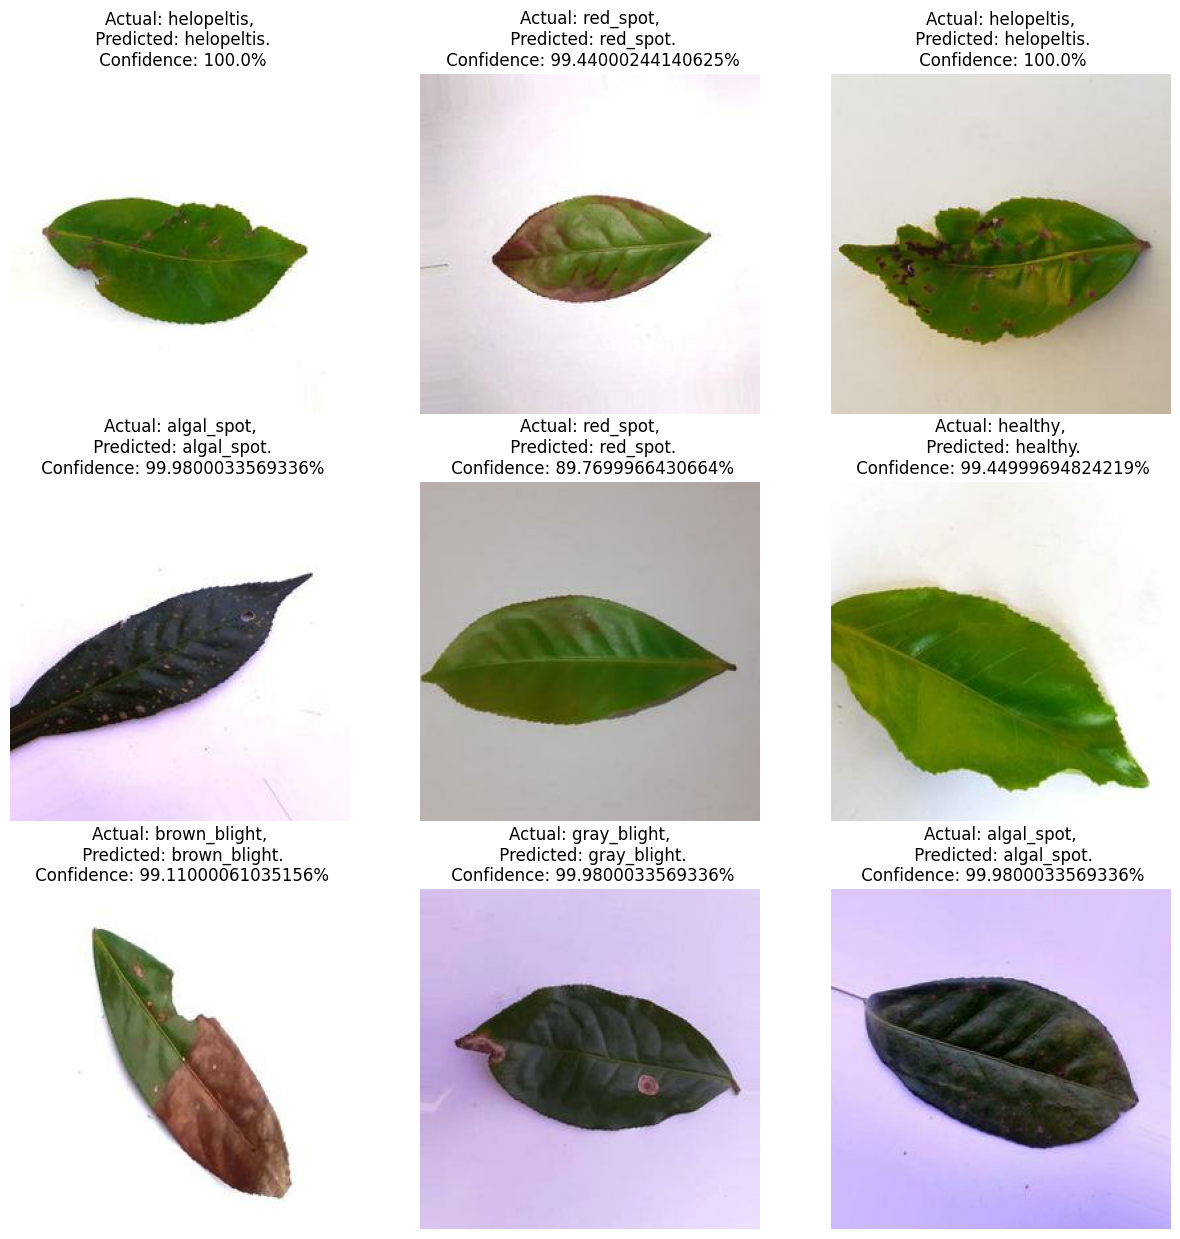

In [33]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Model Loading and Testing
This section demonstrates how to:
1. Load a previously saved model
2. Load and preprocess a single test image
3. Make a prediction on that image
4. Display the results with confidence score

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


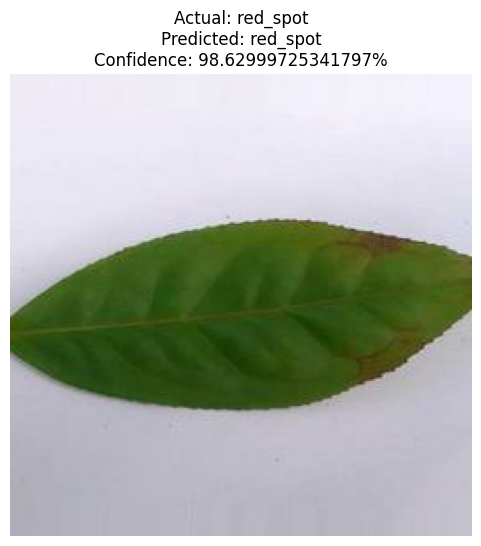

In [27]:
# Load the saved model
loaded_model = tf.keras.models.load_model('models/tea_leaf_model.keras')

# Get a random image from the test dataset
for images_batch, labels_batch in test_ds.take(1):
    # Get a random index
    random_idx = np.random.randint(0, BATCH_SIZE)
    test_image = images_batch[random_idx].numpy().astype("uint8")
    true_label = class_names[labels_batch[random_idx]]
    
    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(test_image)
    
    # Preprocess the image for prediction
    img_array = tf.expand_dims(test_image, 0)  # Create a batch
    
    # Make prediction
    predictions = loaded_model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    
    # Display results
    plt.title(f'Actual: {true_label}\nPredicted: {predicted_class}\nConfidence: {confidence}%')
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


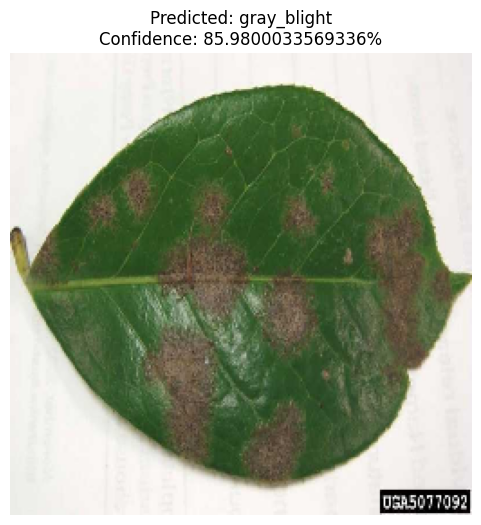

In [38]:
def predict_external_image(model, image_path):
    # Read the image
    img = tf.keras.preprocessing.image.load_img(
        image_path, 
        target_size=(IMAGE_SIZE, IMAGE_SIZE)
    )
    
    # Convert to array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # Expand dimensions to create batch
    img_array = tf.expand_dims(img_array, 0)
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    
    # Display results
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence}%')
    plt.axis('off')
    plt.show()
    
    return predicted_class, confidence


# Load the saved model
loaded_model = tf.keras.models.load_model('models/tea_leaf_model.keras')

# Path to your downloaded image
image_path = "image.png"  # Replace with your image path

# Make prediction
predicted_class, confidence = predict_external_image(loaded_model, image_path)